# Machine Learning Attack on Arbiter PUF
## Justin Schubeck, Alex Liu, Yash Bhat
### EEE5716 - Introduction to Hardware Security and Trust: Fall 2022
---

Import necessary packages.

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
from sklearn.model_selection import StratifiedKFold
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import accuracy_score
from sklearn.model_selection import cross_val_score
from scipy import stats

Read in the data, and format to be [-1, 1] instead of [0, 1].

In [2]:
df = pd.read_excel('CRPSets.xls',header=None)
df = df.replace(0,-1)
df

,0,1,2,3,4,5,6,7,8,9,...,55,56,57,58,59,60,61,62,63,64
0,-1,-1,1,1,1,-1,1,-1,-1,1,...,1,1,-1,-1,-1,1,-1,1,1,1
1,1,-1,1,-1,1,-1,-1,-1,1,-1,...,1,1,1,-1,-1,-1,-1,-1,1,-1
2,1,1,-1,1,-1,1,1,-1,1,-1,...,1,-1,1,1,1,-1,-1,1,-1,-1
3,-1,1,-1,-1,-1,-1,1,1,-1,1,...,1,1,1,1,1,-1,-1,1,1,-1
4,1,1,-1,-1,-1,1,1,1,-1,1,...,-1,1,-1,1,1,1,1,-1,-1,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11995,-1,1,-1,1,1,1,-1,-1,1,-1,...,1,-1,-1,-1,-1,1,1,-1,-1,-1
11996,-1,1,-1,-1,1,1,-1,1,-1,1,...,1,1,1,-1,-1,1,-1,1,-1,1
11997,1,1,1,-1,-1,-1,1,1,-1,-1,...,1,1,-1,1,-1,1,1,-1,-1,-1
11998,-1,1,-1,1,1,1,1,1,1,1,...,-1,-1,-1,-1,1,-1,1,-1,-1,1


Separate the challenges from responses, and extract features.

In [3]:
challenges = df.to_numpy()[:,:64]
responses = df.to_numpy()[:,64]
features = np.cumprod(np.fliplr(challenges), axis=1, dtype=np.int8)

## Support Vector Machine

In [4]:
# Initialize lists for data collection.
best_estimators = []
best_params = []
train_acc = []
test_acc = []
lower_conf = []
upper_conf = []

# Train-Test splits of CRPs.
ratios = np.concatenate((np.array(list(range(25,100,25)))/12000,
                         np.array(list(range(100,1000,100)))/12000,
                         np.array(list(range(1000,12000,1000)))/12000))

# Iterate training models over all splits.
for ratio in ratios:
    
    # Split the data into training and test splits.
    X_train, X_test, t_train, t_test = train_test_split(features, 
                                                        responses,
                                                        train_size=ratio,
                                                        shuffle=True,
                                                        random_state=7,
                                                        stratify=responses)
    
    # Define a set of hyperparameters to tune.
    param_grid = {'C':np.logspace(-3,3,7),
                  'kernel':['linear','rbf'],
                  'gamma':list(np.logspace(-3,3,7))+['scale','auto']}

    # Define cross validation strategy.
    cv = StratifiedKFold(n_splits=5, 
                         shuffle=True,
                         random_state=7)

    # Create hyperparameter testing structure. 
    grid_search = GridSearchCV(SVC(), 
                               param_grid=param_grid,
                               cv=cv,
                               scoring='accuracy',
                               refit=True,
                               n_jobs=-1)

    # Tune the SVM model.
    grid_search.fit(X_train, t_train)
    best_estimators += [grid_search.best_estimator_]
    best_params += [grid_search.best_params_]

    # Predict training responses.
    y_train = grid_search.best_estimator_.predict(X_train)
    train_acc += [accuracy_score(t_train, y_train)]

    # Predict test responses.
    y_test = grid_search.best_estimator_.predict(X_test)
    test_acc += [accuracy_score(t_test, y_test)]
    
    # Calculate 10 accuracy scores using cross validation on best model.
    scores = cross_val_score(grid_search.best_estimator_,
                             X_train,
                             t_train,
                             scoring='accuracy',
                             cv=10)
    
    # Generate a 95% confidence interval on the test accuracy prediction.
    interval = stats.t.interval(0.95, 
               len(scores) - 1,
               loc=scores.mean(),
               scale=scores.std(ddof=1)/np.sqrt(len(scores)))
    lower_conf += [interval[0]]
    upper_conf += [interval[1]]

Logging values for each model.

In [19]:
ratios*12000

array([   25.,    50.,    75.,   100.,   200.,   300.,   400.,   500.,
         600.,   700.,   800.,   900.,  1000.,  2000.,  3000.,  4000.,
        5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000.])

In [5]:
best_params

[{'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 1.0, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10.0, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 10.0, 'gamma': 0.01, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'rbf'},
 {'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 0.1, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 10.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 100.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 1000.0, 'gamma': 0.001, 'kernel': 'linear'},
 {'C': 100.0, 'gamm

In [6]:
best_estimators

[SVC(C=0.1, gamma=0.001, kernel='linear'),
 SVC(gamma=0.01),
 SVC(gamma=0.01),
 SVC(C=10.0, gamma=0.001),
 SVC(C=10.0, gamma=0.01),
 SVC(C=10.0, gamma=0.01),
 SVC(C=0.1, gamma=0.001, kernel='linear'),
 SVC(C=1000.0, gamma=0.001),
 SVC(C=0.1, gamma=0.001, kernel='linear'),
 SVC(C=10.0, gamma=0.001, kernel='linear'),
 SVC(C=1000.0, gamma=0.001),
 SVC(C=10.0, gamma=0.001, kernel='linear'),
 SVC(C=0.1, gamma=0.001, kernel='linear'),
 SVC(C=10.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=1000.0, gamma=0.001, kernel='linear'),
 SVC(C=1000.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=100.0, gamma=0.001, kernel='linear'),
 SVC(C=1000.0, gamma=0.001, kernel='linear')]

In [7]:
train_acc

[1.0,
 1.0,
 1.0,
 0.98,
 1.0,
 1.0,
 0.98,
 1.0,
 0.9816666666666667,
 1.0,
 1.0,
 1.0,
 0.974,
 0.9985,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 0.9995555555555555,
 0.9992,
 1.0]

In [8]:
test_acc

[0.6982881002087683,
 0.6758995815899581,
 0.7477568134171908,
 0.8163865546218487,
 0.8680508474576272,
 0.8804273504273504,
 0.9043103448275862,
 0.935304347826087,
 0.9363157894736842,
 0.9567256637168141,
 0.9558035714285714,
 0.9548648648648649,
 0.9532727272727273,
 0.988,
 0.9885555555555555,
 0.991875,
 0.9941428571428571,
 0.9945,
 0.9938,
 0.995,
 0.9946666666666667,
 0.9965,
 0.998]

In [9]:
lower_conf

[0.5454152743753193,
 0.559351617987147,
 0.6538312283302322,
 0.6374809888837991,
 0.8817859431399552,
 0.8554420710059591,
 0.8886818522171743,
 0.9094108474732326,
 0.9186621982690928,
 0.9411651366401025,
 0.9414965165242757,
 0.9482579420118066,
 0.945790205367151,
 0.9776570108525163,
 0.9850089307290959,
 0.9923340222168601,
 0.9933265242603575,
 0.9940599631074988,
 0.994015875752269,
 0.9952185123610476,
 0.9963813497567361,
 0.9956122023325912,
 0.9957267769953407]

In [10]:
upper_conf

[0.9545847256246807,
 0.8006483820128528,
 0.8211687716697679,
 0.8825190111162009,
 0.9382140568600447,
 0.9378912623273745,
 0.9513181477828255,
 0.9425891525267672,
 0.9513378017309071,
 0.9731205776456117,
 0.9710034834757244,
 0.9695198357659712,
 0.9682097946328487,
 0.9873429891474835,
 0.9936577359375707,
 0.9976659777831397,
 0.9982734757396425,
 0.9982733702258345,
 0.9985555528191594,
 0.9982814876389526,
 0.9985075391321526,
 0.9989877976674085,
 0.9984550411864778]

Visual display of SVM results.

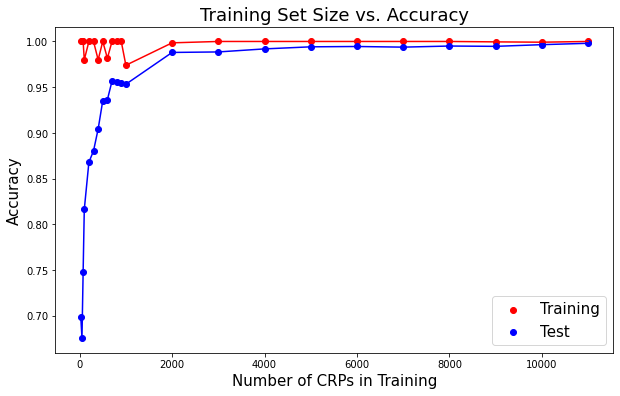

In [15]:
plt.figure(figsize=(10,6));

# Plot training accuracies.
plt.plot(ratios*12000, train_acc, color='red');
plt.scatter(ratios*12000, train_acc, color='red', label='Training');

# Plot test accuracies.
plt.plot(ratios*12000, test_acc, color='blue');
plt.scatter(ratios*12000, test_acc, color='blue', label='Test');

plt.title('Training Set Size vs. Accuracy', size=18);
plt.xlabel('Number of CRPs in Training', size=15);
plt.ylabel('Accuracy', size=15);
plt.legend(prop={'size': 15});

## Logistic Regression

In [27]:
# Initialize lists for data collection.
best_estimators = []
best_params = []
train_acc = []
test_acc = []
lower_conf = []
upper_conf = []

# Train-Test splits of CRPs.
ratios = np.concatenate((np.array(list(range(25,100,25)))/12000,
                         np.array(list(range(100,1000,100)))/12000,
                         np.array(list(range(1000,12000,1000)))/12000))

# Iterate training models over all splits.
for ratio in ratios:
    
    # Split the data into training and test splits.
    X_train, X_test, t_train, t_test = train_test_split(features, 
                                                        responses,
                                                        train_size=ratio,
                                                        shuffle=True,
                                                        random_state=7,
                                                        stratify=responses)
    
    # Define a set of hyperparameters to tune.
    param_grid = {'penalty':['l2','none'],
                  'C':np.logspace(-3,3,7),
                  'solver':['newton-cg', 'lbfgs', 'sag', 'saga'],
                  'max_iter':[3000]}

    # Define cross validation strategy.
    cv = StratifiedKFold(n_splits=5, 
                         shuffle=True,
                         random_state=7)

    # Create hyperparameter testing structure. 
    import warnings
    warnings.filterwarnings("ignore", message="Setting penalty='none' will ignore the C and l1_ratio parameters")
    grid_search = GridSearchCV(LogisticRegression(), 
                               param_grid=param_grid,
                               cv=cv,
                               scoring='accuracy',
                               refit=True,
                               n_jobs=-1)

    # Tune the LR model.
    grid_search.fit(X_train, t_train)
    best_estimators += [grid_search.best_estimator_]
    best_params += [grid_search.best_params_]

    # Predict training responses.
    y_train = grid_search.best_estimator_.predict(X_train)
    train_acc += [accuracy_score(t_train, y_train)]

    # Predict test responses.
    y_test = grid_search.best_estimator_.predict(X_test)
    test_acc += [accuracy_score(t_test, y_test)]
    
    # Calculate 10 accuracy scores using cross validation on best model.
    scores = cross_val_score(grid_search.best_estimator_,
                             X_train,
                             t_train,
                             scoring='accuracy',
                             cv=10)
    
    # Generate a 95% confidence interval on the test accuracy prediction.
    interval = stats.t.interval(0.95, 
               len(scores) - 1,
               loc=scores.mean(),
               scale=scores.std(ddof=1)/np.sqrt(len(scores)))
    lower_conf += [interval[0]]
    upper_conf += [interval[1]]

Logging values for each model.

In [28]:
ratios*12000

array([   25.,    50.,    75.,   100.,   200.,   300.,   400.,   500.,
         600.,   700.,   800.,   900.,  1000.,  2000.,  3000.,  4000.,
        5000.,  6000.,  7000.,  8000.,  9000., 10000., 11000.])

In [29]:
best_params

[{'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'newton-cg'},
 {'C': 1.0, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 1.0, 'max_iter': 3000, 'penalty': 'none', 'solver': 'sag'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'newton-cg'},
 {'C': 1.0, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'saga'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'newton-cg'},
 {'C': 10.0, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'saga'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'lbfgs'},
 {'C': 10.0, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'newton-cg'},
 {'C': 0.001, 'max_iter': 3000, 'penalty': 'none', 'solver': 'lbfgs'},
 {'C': 100.0, 'max_iter': 3000, 'penalty': 'l2', 'solver': 'newto

In [30]:
best_estimators

[LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='newton-cg'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='newton-cg'),
 LogisticRegression(max_iter=3000, solver='newton-cg'),
 LogisticRegression(max_iter=3000, penalty='none', solver='sag'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='newton-cg'),
 LogisticRegression(max_iter=3000, solver='newton-cg'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='saga'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='newton-cg'),
 LogisticRegression(C=10.0, max_iter=3000, solver='newton-cg'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none', solver='saga'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none'),
 LogisticRegression(C=10.0, max_iter=3000, solver='newton-cg'),
 LogisticRegression(C=0.001, max_iter=3000, penalty='none'),
 LogisticRegression(C=100.0, max_iter=3000, solver='newton-cg'),
 LogisticRegression(C=100.0, ma

In [31]:
train_acc

[1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0,
 1.0]

In [32]:
test_acc

[0.7064718162839249,
 0.717489539748954,
 0.7961425576519916,
 0.8280672268907563,
 0.8630508474576272,
 0.8996581196581197,
 0.9168103448275862,
 0.9224347826086956,
 0.9471929824561404,
 0.9567256637168141,
 0.963125,
 0.9635135135135136,
 0.9737272727272728,
 0.9911,
 0.9895555555555555,
 0.994,
 0.9941428571428571,
 0.9933333333333333,
 0.995,
 0.9955,
 0.9943333333333333,
 0.9975,
 0.997]

In [33]:
lower_conf

[0.5454152743753193,
 0.6708899571190191,
 0.657147484132205,
 0.690267921872878,
 0.8736818522171743,
 0.8664505393290493,
 0.9032312082271344,
 0.9147645803759583,
 0.9195801648139663,
 0.9467498806607417,
 0.9586741295245832,
 0.955425917351829,
 0.9459351617987146,
 0.9781547311656396,
 0.9854874466840907,
 0.9923340222168601,
 0.993488653314775,
 0.9945738777623125,
 0.9946734824651404,
 0.9968689214186295,
 0.9961057079276706,
 0.9947552544262747,
 0.9957538621173503]

In [34]:
upper_conf

[0.9545847256246807,
 0.8091100428809809,
 0.8178525158677951,
 0.9497320781271219,
 0.9363181477828255,
 0.9468827940042844,
 0.9667687917728655,
 0.9652354196240418,
 0.9604198351860334,
 0.9818215479106871,
 0.9688258704754166,
 0.9779074159815041,
 0.9700648382012851,
 0.9888452688343603,
 0.9965125533159097,
 0.9976659777831397,
 0.9977113466852249,
 0.998092788904354,
 0.9978979461062885,
 0.9991310785813705,
 0.9981165142945515,
 0.9990447455737251,
 0.9980643197008314]

Visual display of LR results.

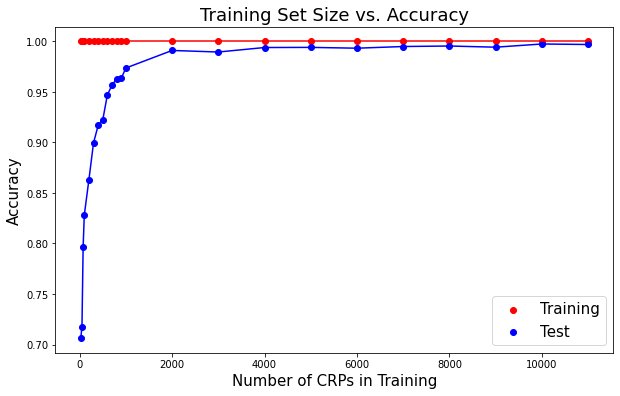

In [35]:
plt.figure(figsize=(10,6));

# Plot training accuracies.
plt.plot(ratios*12000, train_acc, color='red');
plt.scatter(ratios*12000, train_acc, color='red', label='Training');

# Plot test accuracies.
plt.plot(ratios*12000, test_acc, color='blue');
plt.scatter(ratios*12000, test_acc, color='blue', label='Test');

plt.title('Training Set Size vs. Accuracy', size=18);
plt.xlabel('Number of CRPs in Training', size=15);
plt.ylabel('Accuracy', size=15);
plt.legend(prop={'size': 15});